# Analysis Selection

#### The goal of this session is to learn how one can design and implement a basic "cut"-based analysis selection. 
We haven't covered staistical analysis yet, but intuitively, our analysis is generally "better" when we expect more signal events and fewer background events. Therefore, we want to design a set of "cuts" (requirements on certain physics observables in our data) which remove as many backround events as possible, while retaining as much signal as possible.  
In reality, our cuts will usually remove both signal and backgroudn events, so we need to find the best compromise when defining our cuts. If you had a lot of computing resources and time, you could skip ahead to the statistical analysis section of this tutorial and calculate the full sensitivity (basicall, how good the analysis is) for every cut value and choose whichever value maximizes sensitivity. In reality, this isn't really feasible (or fun). So, we'll learn some tricks to estimate our analysis sensitivity along the way. 

### As usual, we'll start by loading the packages we need

In [1]:
import numpy as np
import pandas as pd
import os 
import itertools 
import uproot
import awkward as ak
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.analysis_tools import Weights
from ntuple_schema import NtupleSchema
import hist
import vector
vector.register_awkward()

import pickle 
from dask_jobqueue import SLURMCluster
from distributed import Client

import mplhep as hep
import matplotlib.pyplot as plt


In [2]:
# Define some useful quantities 

GeV = 1000
luminosity = 2478.52 #pb-1

### We next define the input ntuples, which we created earlier in the tutorial

We will store them in a dictionary to more easily fetch each file later on. This will also allow us to perform similar tasks, such as loading events and applying selections, in loops. 

Note that we have _a lot_ of signal files! For this tutorial, we'll simplify our lives a bit by optimizing our selection to just a few different signal benchmark masses: a "low mass" (700 GeV), "medium mass" (1200), and "high mass" (1800 GeV). 

In [3]:
# # This is just a big dictionary to store filenames, plot colors, etc. for easier (and more consistent) use later on

# refdict = { 
    
#     # Up-type Signals, electron channel
#     # "sig_el_LQu_700": { 
#     #     "long_name": "LQu Signal, 700 GeV $e$",
#     #     "ntup_filenames": ["FullCPAlgorithmsTest.mc.hist.root"],
#     #     "plt_color": "lightskyblue"
#     # } ,     
    
#     #Up-type Signals, electron channel
#     "sig_el_LQu_700": { 
#         "long_name": "LQu Signal, 700 GeV el",
#         "ntup_filenames": [
#             "output_312261/"
#         ],
#         "subdir": "signal/",
#         "plt_color": "lightskyblue",
#     } , 
#     "sig_el_LQu_1200": { 
#         "long_name": "LQu Signal, 1200 GeV el",
#         "ntup_filenames": [
#             "output_312293/"
#         ],
#         "subdir": "signal/",
#         "plt_color": "royalblue"
#     } , 
#     # "sig_el_LQu_1800": {
#     #     "long_name": "LQu Signal, 1800 GeV el",
#     #     "ntup_filenames": [
#     #         "output_312325/"
#     #     ],
#     #     "subdir": "signal/",
#     #     "plt_color": "navy"
#     # } , 
    
#     # # Down-type signals, electron channel
#     # "sig_el_LQd_700": {
#     #     "long_name": "LQd Signal, 700 GeV el",
#     #     "ntup_filenames": ["user.rasmith.312259.aMcAtNloPy8EG_A14N30NLO_LQd_el_ld_0p3_beta_0p5_2ndG_M700.PHYS.e7587a875r10201p5001.Ntuple_ANALYSIS"],
#     #     "subdir": "signal_e/",
#     #     "plt_color": "lightcoral"
#     # } , 
#     # "sig_el_LQd_1200": { 
#     #     "long_name": "LQd Signal, 1200 GeV el",
#     #     "ntup_filenames": ["user.rasmith.312291.aMcAtNloPy8EG_A14N30NLO_LQd_el_ld_0p3_beta_0p5_2ndG_M1200.PHYS.e7587a875r10201p5001.Ntuple_ANALYSIS"],
#     #     "subdir": "signal_e/",
#     #     "plt_color": "firebrick"
#     # } , 
#     # "sig_el_LQd_1800": {
#     #     "long_name": "LQd Signal, 1800 GeV el",
#     #     "ntup_filenames": ["user.rasmith.312323.aMcAtNloPy8EG_A14N30NLO_LQd_el_ld_0p3_beta_0p5_2ndG_M1800.PHYS.e7587a875r10201p5001.Ntuple_ANALYSIS"],
#     #     "subdir": "signal_e/",
#     #     "plt_color": "maroon"
#     # } , 
    
    
#     # W+jets background 
#     "bkg_Wjets": { 
#         "long_name": "W+jets Background",
#         "ntup_filenames": [
#             "output_700338/" , # Wenu_maxHTpTV2_BFilter 
#             "output_700339/" , # Wenu_maxHTpTV2_CFilterBVeto 
#             "output_700340/" , # Wenu_maxHTpTV2_CVetoBVeto 
#             "output_700341/" , # Wmunu_maxHTpTV2_BFilter 
#             "output_700342/" , # Wmunu_maxHTpTV2_CFilterBVeto 
#             "output_700343/" , # Wmunu_maxHTpTV2_CVetoBVeto 
#             "output_700344/" , # Wtaunu_L_maxHTpTV2_BFilter 
#             "output_700345/" , # Wtaunu_L_maxHTpTV2_CFilterBVeto 
#             "output_700346/" , # Wtaunu_L_maxHTpTV2_CVetoBVeto 
#             "output_700347/" , # Wtaunu_H_maxHTpTV2_BFilter 
#             "output_700348/" , # Wtaunu_H_maxHTpTV2_CFilterBVeto 
#             "output_700349/" , # Wtaunu_H_maxHTpTV2_CVetoBVeto 
#         ],
#         "subdir": "wjets/",
#         "plt_color": "green"
#     } , 
    
#     # Z+jets background 
#     "bkg_Zjets": { 
#         "long_name": "Z+jets Background",
#         "ntup_filenames": [
#             "output_700320/" , # Zee_maxHTpTV2_BFilter
#             "output_700321/" , # Zee_maxHTpTV2_CFilterBVeto
#             "output_700322/" , # Zee_maxHTpTV2_CVetoBVeto
#             "output_700323/" , # Zmumu_maxHTpTV2_BFilter
#             "output_700324/" , # Zmumu_maxHTpTV2_CFilterBVeto
#             "output_700325/" , # Zmumu_maxHTpTV2_CVetoBVeto
#             "output_700326/" , # Ztautau_LL_maxHTpTV2_BFilter
#             "output_700327/" , # Ztautau_LL_maxHTpTV2_CFilterBVeto
#             "output_700328/" , # Ztautau_LL_maxHTpTV2_CVetoBVeto
#             "output_700329/" , # Ztautau_LH_maxHTpTV2_BFilter
#             "output_700330/" , # Ztautau_LH_maxHTpTV2_CFilterBVeto
#             "output_700331/" , # Ztautau_LH_maxHTpTV2_CVetoBVeto
#             "output_700332/" , # Ztautau_HH_maxHTpTV2_BFilter
#             "output_700333/" , # Ztautau_HH_maxHTpTV2_CFilterBVeto
#             "output_700334/" , # Ztautau_HH_maxHTpTV2_CVetoBVeto
#         ],
#         "subdir": "zjets/",
#         "plt_color": "darkorange"
#     } , 
    

#     # Diboson background 
#     "bkg_diboson": {
#         "long_name": "Diboson Background",
#         "ntup_filenames": [
#             "output_363356/" , # ZqqZll
#             "output_363358/" , # WqqZll
#             "output_364250/" , # llll 
#             "output_364253/" , # lllv 
#             "output_364254/" , # llvv 
#         ],
#         "subdir": "diboson/",
#         "plt_color": "darkcyan"
#     } , 

 
#     # Single Top background 
#     "bkg_singlet": { 
#         "long_name": "Single $t$ Background",
#         "ntup_filenames": [
#             "output_410644/", # singletop_schan_lept_top
#             "output_410645/", # singletop_schan_lept_antitop
#             "output_410648/", # Wt_DR_dilepton_top
#             "output_410649/", # Wt_DR_dilepton_antitop
#             "output_410658/", # tchan_BW50_lept_top
#             "output_410659/", # tchan_BW50_lept_antitop
#         ],
#         "subdir": "singletop/",
#         "plt_color": "darkviolet"
#     } , 
    
#     # Top-Antitop background 
#     "bkg_ttbar": { 
#         "long_name": "$t\bar{t}$ Background",
#         "ntup_filenames": [
#             "output_410472/",  # ttbar
#         ],
#         "subdir": "ttbar/",
#         "plt_color": "darkviolet"
#     } , 

# }

In [4]:
refdict = { 
    
    #Up-type Signals, electron channel
    "sig_el_LQu_700": { 
        "long_name": "LQu Signal, 700 GeV el",
        "ntup_filenames": {
            "output_312261/": {"DSID": 312261, "xsec": 7.30E-02, "kfactor": 1.0},
        },
        "subdir": "signal/",
        "plt_color": "red",
    },
    
    #Zee + jets
    "zjets": { 
        "long_name": "Zee+jets",
        "ntup_filenames": {
            "output_700320/": {"DSID": 700320, "xsec": 55.5413852,  "kfactor": 1.0},
            "output_700321/": {"DSID": 700321, "xsec": 286.392209,  "kfactor": 1.0},
            "output_700322/": {"DSID": 700322, "xsec": 1879.375291, "kfactor": 1.0},
        },
        "subdir": "zjets/",
        "plt_color": "lightskyblue",
    },
    
    #ttbar
    "ttbar": { 
        "long_name": "ttbar",
        "ntup_filenames": {
            "output_410472/": {"DSID": 410472, "xsec": 76.95,  "kfactor": 1.1398},
        },
        "subdir": "ttbar/",
        "plt_color": "forestgreen",
    },
    
    #Wev + jets
    "wjets": { 
       "long_name": "Wev+jets",
       "ntup_filenames": {
           "output_700338/": {"DSID": 700338, "xsec": 204.4487228, "kfactor": 1.0},
           "output_700339/": {"DSID": 700339, "xsec": 3194.76948,  "kfactor": 1.0},
           "output_700340/": {"DSID": 700340, "xsec": 18342.85572, "kfactor": 1.0},
       },
       "subdir": "wjets/",
       "plt_color": "darkgoldenrod",
    },
    
    #diboson
    "diboson": { 
       "long_name": "Diboson",
       "ntup_filenames": {
           "output_363356/": {"DSID": 363356, "xsec": 15.563,  "kfactor": 0.13961},
           "output_363358/": {"DSID": 363358, "xsec": 3.437,   "kfactor": 1.0},
           "output_364250/": {"DSID": 364250, "xsec": 1.2523,  "kfactor": 1.0},
           "output_364253/": {"DSID": 364253, "xsec": 4.5832,  "kfactor": 1.0},
           "output_364254/": {"DSID": 364254, "xsec": 12.501,  "kfactor": 1.0},
       },
       "subdir": "diboson/",
       "plt_color": "darkgray",
    },
    
    #singletop
    "singletop": { 
       "long_name": "Single Top",
       "ntup_filenames": {
           "output_410644/": {"DSID": 410644, "xsec": 2.0268,  "kfactor": 1.015},
           "output_410645/": {"DSID": 410645, "xsec": 1.2676,  "kfactor": 1.015},
           "output_410648/": {"DSID": 410648, "xsec": 3.9968,  "kfactor": 0.945},
           "output_410649/": {"DSID": 410649, "xsec": 3.9940,  "kfactor": 0.946},
           "output_410658/": {"DSID": 410658, "xsec": 36.993,  "kfactor": 1.191},
           "output_410659/": {"DSID": 410659, "xsec": 22.175,  "kfactor": 1.183},
       },
       "subdir": "singletop/",
       "plt_color": "royalblue",
    },
    
    
}

In [5]:
# A couple of input files are empty; we'll list them here to more easily skip over them later 
files_to_skip = [
    'DAOD_PHYS_28116736__000041',
    'DAOD_PHYS_28116736__000023',
    'DAOD_PHYS_28116736__000015',
    'DAOD_PHYS_28116736__000034',
    'DAOD_PHYS_28116736__000021',
    'DAOD_PHYS_28116736__000040',
    'DAOD_PHYS_28116736__000033',
    'DAOD_PHYS_28116736__000017',
    'DAOD_PHYS_28116736__000028',
    'DAOD_PHYS_28116736__000029',
    'DAOD_PHYS_28116736__000042'
    'DAOD_PHYS_28264840__000076',
    'DAOD_PHYS_28264840__000166',
    'DAOD_PHYS_28264840__000022',
    'DAOD_PHYS_28264840__000025',
    'DAOD_PHYS_28264840__000108',
    'DAOD_PHYS_28264840__000055',
    'DAOD_PHYS_28264840__000103',
    'DAOD_PHYS_28264840__000030',
    'DAOD_PHYS_28264840__000001',
    'DAOD_PHYS_28264840__000089',
    'DAOD_PHYS_28264840__000094',
    'DAOD_PHYS_28264840__000003',
    'DAOD_PHYS_28264840__000105',
    'DAOD_PHYS_28264840__000043',
    'DAOD_PHYS_28264840__000045',
    'DAOD_PHYS_28264840__000063',
    'DAOD_PHYS_28264840__000067',
    'DAOD_PHYS_28264840__000141',
    'DAOD_PHYS_28264840__000167',
    'DAOD_PHYS_28264840__000077',
    'DAOD_PHYS_28264840__000139',
    'DAOD_PHYS_28264840__000070',
    'DAOD_PHYS_28264840__000005',
    'DAOD_PHYS_28264840__000159',
    'DAOD_PHYS_28264840__000082',
    'DAOD_PHYS_28264840__000150',
    'DAOD_PHYS_28264840__000099',
    'DAOD_PHYS_28264840__000169',
    'DAOD_PHYS_28264840__000073',
    'DAOD_PHYS_28264840__000080',
    'DAOD_PHYS_28264840__000163',
    'DAOD_PHYS_28264840__000145',
    'DAOD_PHYS_28264840__000041',
    'DAOD_PHYS_28264840__000101',
    'DAOD_PHYS_28264840__000153',
    'DAOD_PHYS_28264840__000050',
    'DAOD_PHYS_28264840__000085',
    'DAOD_PHYS_28264840__000081',
    'DAOD_PHYS_28264840__000086',
    'DAOD_PHYS_28264840__000146',
    'DAOD_PHYS_28264840__000142',
    'DAOD_PHYS_28264840__000053',
    'DAOD_PHYS_28264840__000009',
    'DAOD_PHYS_28264840__000138',
    'DAOD_PHYS_28264840__000042',
    'DAOD_PHYS_28264840__000109',
    'DAOD_PHYS_28264840__000072',
    'DAOD_PHYS_28264840__000049',
    'DAOD_PHYS_28264840__000051'
]


In [6]:
#file_path = "/gpfs/slac/atlas/fs1/d/recsmith/aswt/samples/FullCPAlgorithmsTest.mc.hist.root"
#file_path = "./example_ntuple/"
#file_path = "/gpfs/slac/atlas/fs1/d/rhyneman/ast/"

file_path = "/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples/"

#### Let's Talk Briefly About Missing Transverse Energy 
 Missing Transverse Energy ("MET") is a measure of how "imbalanced" an event is. In our ntuples, different stages of the MET calculation are saved. You can see below the name for each stage, as well as the actual MET calculated at each stage, for just the first event in our signal ntuple. So, just remember that you'll need to fetch the last subentry for the MET in our files. 


In [7]:
#Open one of the subfiles making up the signal, just to play around with MET
# ex_file_dir = f"{file_path}/{refdict['sig_el_LQd_700']['subdir']}/{refdict['sig_el_LQd_700']['ntup_filenames'][0]}" 
# ex_file_name = f"{ex_file_dir}/{os.listdir(ex_file_dir)[0]}"
# ex_file = uproot.open(ex_file_name)

# my_met_names = ex_file['analysis']['met_name_NOSYS'].arrays(library='np')['met_name_NOSYS'][0]
# my_met = ex_file['analysis']['met_sumet_NOSYS'].arrays(library='np')['met_sumet_NOSYS'][0]
# for (name,val) in zip(my_met_names,my_met): print(name,': ',val)


### The "Preselection" 
We can start by applying the analysis' "preselection." These are the cuts which help us broadly target the final state we want. This analysis targets a final state with two leptons and two jets, so our preselection will include those requirements. 
You can find the analysis' preselection below: 
- Exactly 2 leptons (e/$\mu$) with opposite charge 
- At least 2 jets 
- The leptons must have a $p_{T}\geq27$ GeV
- The two "leading" jets (those with the largest $p_{T}$) must have $p_{T}\geq 45$ GeV
- The "MET Significance" (the $\frac{E_{T}^{\text{Miss}}} {\sqrt{\Sigma p_{T}}}$) should be $\leq 3.5$ GeV
- The di-lepton system must have a $p_{T}\geq75$ GeV

You might be wondering why we apply the $p_{T}$ cuts on the leptons. This is to ensure that the trigger is "fully efficient," which just means that essentially all events with a lepton with that $p_{T}$ will pass the trigger. If our trigger is not fully efficient, we need to consider how the trigger efficiency in our Monte Carlo differs form that in real data. This is extra work for the analysis that may not really be worth the effort (many of our physics signals-of-interest involve high-$p_{T}$ objects anyways, so we aren't losing much signal). Keep this trade-off in mind when you start working on your own analysis! 

#### Technical Notes 
We'll continue to use Coffea and uproot to load and process our data. The following code should look familiar (if not, take a step back to "Plotting the Z Peak." There, the only selection we applied to our signal sample was to require that we have two electrons with opposite charge. We'll also use a new coffea method, run_uproot_job, to apply our schema to our ntuple files, instead of the NanoEventsFactory.
Below, you can see how we can expand our code to apply a much more complex selection with different stages. 

In [8]:
# This is just a quick example of how to use the "NanoEventsFactory.from_root" method to apply the schema to our 
# many individual files. But, it becomes non-trivial to combine a lot of files into a single samples (which is 
# unfortunate when each of our samples has so many subfiles... 
# We'll use a different method below to do this in a much nicer way! 

# files = {} 
# for key in refdict: 
#     infilelist = refdict[key]['ntup_filenames']
#     files[key] = [] 
#     for filename in infilelist: 
#         file_loc = f"{file_path}/{refdict[key]['subdir']}/{filename}/"
#         subfiles = os.listdir(file_loc)
#         for subfile in subfiles:
#             files[key].append( uproot.open(f"{file_loc}/{subfile}") )
    


# all_events = {} 

# for sampletype in files.keys(): 
#     all_events[sampletype] = []
#     for file in files[sampletype]: 
#         file_loc = f"{file_path}/{refdict[key]['subdir']}/{filename}/" 
#         subfiles = os.listdir(file_loc)
#         for subfile in subfiles:
#             all_events[sampletype].append(
#                 NanoEventsFactory.from_root(
#                     file, "analysis", metadata={"dataset": "Z$\\rightarrow e \\bar{e}$ "+sampletype}, schemaclass=NtupleSchema,
#                 ).events()
#             )


In [9]:
# Note the new preselection applied in our processor! 

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="d_axis", label="", categories=[], growth=True)
        dielec_mass_axis = hist.axis.Regular(name="e0_axis", label="$e\\bar{e}$ mass [GeV]", bins=50, start=0, stop=500)
        met_sig_axis = hist.axis.Regular(name="e1_axis", label=r"$E_{T}^{Miss}$ Sig. [GeV]", bins=50, start=0, stop=5)
        mlq_avg_axis = hist.axis.Regular(name="e2_axis", label=r"Avg. $m_{\ell j}$ [GeV]", bins=50, start=200, stop=1200)
        mlq_asym_axis = hist.axis.Regular(name="e3_axis", label=r"$m_{\ell j}$ Asymm.", bins=50, start=0, stop=1)

        
        self.output = {
            'h_dielec_mass': hist.Hist(dataset_axis, dielec_mass_axis) , 
            'h_met_sig': hist.Hist(dataset_axis, met_sig_axis) , 
            'h_mlq_avg': hist.Hist(dataset_axis, mlq_avg_axis) , 
            'h_mlq_asym': hist.Hist(dataset_axis, mlq_asym_axis) , 
            
            'dielec_mass': processor.defaultdict_accumulator(list),
            #'dielec_pt': processor.defaultdict_accumulator(list) ,
            #'met_sig': processor.defaultdict_accumulator(list) ,
            #'mlq_avg': processor.defaultdict_accumulator(list) ,
            #'mlq_min': processor.defaultdict_accumulator(list) ,
            #'mlq_max': processor.defaultdict_accumulator(list) ,
            #'mlq_asym': processor.defaultdict_accumulator(list) ,
            
            # We can save arrays of the output lepton information 
            #'el1_pt': processor.defaultdict_accumulator(list) ,
            #'el1_eta': processor.defaultdict_accumulator(list) ,
            #'el1_phi': processor.defaultdict_accumulator(list) ,
            #'el1_mass': processor.defaultdict_accumulator(list) ,
  
            #'el2_pt': processor.defaultdict_accumulator(list) ,
            #'el2_eta': processor.defaultdict_accumulator(list) ,
            #'el2_phi': processor.defaultdict_accumulator(list) ,
            #'el2_mass': processor.defaultdict_accumulator(list) ,
            
            #'jet1_pt': processor.defaultdict_accumulator(list) ,
            #'jet1_eta': processor.defaultdict_accumulator(list) ,
            #'jet1_phi': processor.defaultdict_accumulator(list) ,
            #'jet1_mass': processor.defaultdict_accumulator(list) ,            

            #'jet2_pt': processor.defaultdict_accumulator(list) ,
            #'jet2_eta': processor.defaultdict_accumulator(list) ,
            #'jet2_phi': processor.defaultdict_accumulator(list) ,
            #'jet2_mass': processor.defaultdict_accumulator(list) ,   
            
            'weight': processor.defaultdict_accumulator(list) ,   
            
        }
    
    def process(self, events):
        
        elec = events.Electron
        muon = events.Muon
        jet = events.Jet
        met = events.MET
        trig = events.trigPassed
        
        triggers = [ 
            # These are the electron triggers
            'HLT_e26_lhtight_nod0_ivarloose', 
            'HLT_e60_lhmedium', 
            'HLT_e60_lhmedium_nod0', 
            'HLT_e140_lhloose', 
            'HLT_e140_lhloose_nod0', 
            'HLT_e300_etcut', 
            # These are the muon triggers
            # 'HLT_mu50', 
            # 'HLT_mu60_0eta105_msonly', 
            # 'HLT_mu26_ivarmedium' 
        ]

        # Check to make sure one of our triggers was fired
        passTrigger = ( 
            trig.HLT_e26_lhtight_nod0_ivarloose | 
            trig.HLT_e60_lhmedium | 
            trig.HLT_e60_lhmedium_nod0 | 
            trig.HLT_e140_lhloose | 
            trig.HLT_e140_lhloose_nod0 | 
            trig.HLT_e300_etcut
        )
        
        # We only want events with a certain number of objects (otherwise we can't calculate variables like m_ee) 
        dielec_neutral = ( 
            passTrigger &
            (ak.num(elec) == 2) &                     # We want exactly two electrons 
            (ak.sum(elec.charge, axis=1) == 0) &      # We want our electrons to have opposite charge 
            (ak.num(muon) == 0) &                     # We want no muons
            (ak.num(jet) >= 2 )                       # We also need at least two jets 
        )

        
        # Evaluate the electron-and-jet-level preselection (two electrons and two+ jets with pT cuts)
        obj_presel = ( 
            (elec[dielec_neutral,0].pt/GeV >= 27 ) &     # We want our two electrons to have a pT >= 27 GeV 
            (elec[dielec_neutral,1].pt/GeV >= 27 ) & 
            (jet[dielec_neutral,0].pt/GeV >= 45 ) &      # Our jets should have a pT = 45 GeV
            (jet[dielec_neutral,1].pt/GeV >= 45 ) & 
            (jet[dielec_neutral,0].eta <= 2.5 ) &         # Our jets should have an eta <= 2.5 ("central" jet) 
            (jet[dielec_neutral,1].eta <= 2.5 )             
        )
        
#         # This time, let's save the MET Significance, too 
#         # This is a bit more complicated to calculate, but it's just the MET divided by the scalar sum of the e and j pTs 
        met_sig = (
            met[dielec_neutral].sumet[:,-1] / np.sqrt( 
                np.sum(
                    [np.sum(elec[dielec_neutral,:].pt,axis=1),
                    np.sum(jet[dielec_neutral,:2].pt,axis=1)],axis=0  # only want the leading two jets
                )
            )
        )
        
        # Again, let's save the di-electron mass 
        dielec_mass = (elec[dielec_neutral,0] + elec[dielec_neutral,1]).mass
        dielec_pt = (elec[dielec_neutral,0] + elec[dielec_neutral,1]).pt    
    
        
        # Now we can calculate the full preselection with event-level variables 
        # Note that we applied the object (electron and jet) level selection first, since we need those objects 
        # in order to calculate the event level variables below 
        evt_presel =  (
            # The preselection on the jets and electrons, from above 
            obj_presel & 
            # The MET Significance should be <3.5 GeV
            ( met_sig/GeV < 3.5 ) & 
            # Our dilepton system should have a pT > 75 GeV
            ( dielec_pt/GeV > 75 ) &
            # Our dilepton system should have a mass > 130 GeV
            ( dielec_mass/GeV > 130 )             
        )
  
        # We next reconstruct the m_lq values for all lepton-jet pairs 
        # Note that we'll only use the two "leading" jets in pT (those with the highest pT) 
        pairs = ak.cartesian( {'e':elec[dielec_neutral], 'j':jet[dielec_neutral,:2]} ) 
        mlq = ( pairs.e + pairs.j ).mass
        
        # We only have two options for uniquely pairing 2 electrons with 2 jets, so we can define these explicitly below 
        pair_opt_1 = ak.zip( {
            'm1':( elec[dielec_neutral,0] + jet[dielec_neutral,0] ).mass , 
            'm2':( elec[dielec_neutral,1] + jet[dielec_neutral,1] ).mass
        } ) 
        pair_opt_2 = ak.zip( {
            'm1':( elec[dielec_neutral,0] + jet[dielec_neutral,1] ).mass , 
            'm2':( elec[dielec_neutral,1] + jet[dielec_neutral,0] ).mass
        } ) 
        
        # Get the e-j mass system difference from each of our pairing configurations 
        mdiff1 = np.abs( pair_opt_1.m1 - pair_opt_1.m2 )
        mdiff2 = np.abs( pair_opt_2.m1 - pair_opt_2.m2 )
        
        # Store the pair with the smallest mass difference between the e-j pairs 
        closest_pairs = ak.where( (mdiff1 < mdiff2) , pair_opt_1 , pair_opt_2 )
        mlq1,mlq2 = ak.unzip(closest_pairs)
        
        # Essentially separate the mass values into the larger and the smaller values 
        mlq_max = ak.where( (mlq1 > mlq2) , mlq1 , mlq2 )
        mlq_min = ak.where( (mlq1 < mlq2) , mlq1 , mlq2 )
        
        # Calculate some useful variables, like average m_lq and the m_lq asymmetry 
        mlq_avg = 0.5*(mlq_min+mlq_max)
        mlq_asym = ( mlq_max - mlq_min ) / ( mlq_min + mlq_max )

        el1_pt = jet[dielec_neutral][evt_presel,0].pt
        el1_eta = jet[dielec_neutral][evt_presel,0].eta
        el1_phi = jet[dielec_neutral][evt_presel,0].phi
        el1_mass = jet[dielec_neutral][evt_presel,0].mass

        el2_pt = jet[dielec_neutral][evt_presel,1].pt
        el2_eta = jet[dielec_neutral][evt_presel,1].eta
        el2_phi = jet[dielec_neutral][evt_presel,1].phi
        el2_mass = jet[dielec_neutral][evt_presel,1].mass

        jet1_pt = jet[dielec_neutral][evt_presel,0].pt
        jet1_eta = jet[dielec_neutral][evt_presel,0].eta
        jet1_phi = jet[dielec_neutral][evt_presel,0].phi
        jet1_mass = jet[dielec_neutral][evt_presel,0].mass

        jet2_pt = jet[dielec_neutral][evt_presel,1].pt
        jet2_eta = jet[dielec_neutral][evt_presel,1].eta
        jet2_phi = jet[dielec_neutral][evt_presel,1].phi
        jet2_mass = jet[dielec_neutral][evt_presel,1].mass
        
        
        # We also need the "event weight" 
        # Essentially, this accounts for the fact that the raw number of events we simulate is quite large, 
        # but the actual number of events we would expect to see in an experiment is very small. 
        events_selection = events[dielec_neutral][evt_presel]
        if len(events_selection)>0 and events.metadata["sum_of_weights"][0]!=1.0:
            weights = Weights(len(events_selection))
            weights.add(
                "genWeight", 
                events_selection.weight * events.metadata["xsec"][0] * events.metadata["kfactor"][0] * \
                events.metadata["luminosity"][0] / events.metadata["sum_of_weights"][0]
            )
            weight_to_apply = weights.weight()
            #self.output['weight'][dataset] += weight_to_apply
            
        else:
            weight_to_apply = 1.0
            #self.output['weight'][dataset] += ak.Array([]).tolist()
            #weight_to_apply = np.ones_like(dielec_mass[evt_presel],dtype=float)

        dataset = events.metadata['dataset']
        self.output['h_dielec_mass'].fill(d_axis=dataset, e0_axis=dielec_mass[evt_presel]/GeV, weight=weight_to_apply)
        self.output['h_met_sig'].fill(d_axis=dataset, e1_axis=met_sig[evt_presel]/GeV, weight=weight_to_apply)
        self.output['h_mlq_avg'].fill(d_axis=dataset, e2_axis=mlq_avg[evt_presel]/GeV, weight=weight_to_apply)
        self.output['h_mlq_asym'].fill(d_axis=dataset, e3_axis=mlq_asym[evt_presel], weight=weight_to_apply)

        self.output['dielec_mass'][dataset] += ak.to_list(dielec_mass[evt_presel]/GeV)
        
        if len(events_selection)>0 and events.metadata["sum_of_weights"][0]!=1.0:
            self.output['weight'][dataset] += list(weight_to_apply)
        else:
            self.output['weight'][dataset] += list(np.ones_like(dielec_mass[evt_presel],dtype=float))
        """
        self.output['dielec_pt'][dataset] += ak.to_list(dielec_pt[evt_presel]/GeV)
        self.output['met_sig'][dataset] += ak.to_list(met_sig[evt_presel]/GeV)
        self.output['mlq_avg'][dataset] += ak.to_list(mlq_avg[evt_presel]/GeV)
        self.output['mlq_min'][dataset] += ak.to_list(mlq_min[evt_presel]/GeV)
        self.output['mlq_max'][dataset] += ak.to_list(mlq_max[evt_presel]/GeV)
        self.output['mlq_asym'][dataset] += ak.to_list(mlq_asym[evt_presel])

        self.output['el1_pt'][dataset] += ak.to_list(el1_pt/GeV)
        self.output['el1_eta'][dataset] += ak.to_list(el1_eta)
        self.output['el1_phi'][dataset] += ak.to_list(el1_phi)
        self.output['el1_mass'][dataset] += ak.to_list(el1_mass/GeV)

        self.output['el2_pt'][dataset] += ak.to_list(el2_pt/GeV)
        self.output['el2_eta'][dataset] += ak.to_list(el2_eta)
        self.output['el2_phi'][dataset] += ak.to_list(el2_phi)
        self.output['el2_mass'][dataset] += ak.to_list(el2_mass/GeV)       

        self.output['jet1_pt'][dataset] += ak.to_list(jet1_pt/GeV)
        self.output['jet1_eta'][dataset] += ak.to_list(jet1_eta)
        self.output['jet1_phi'][dataset] += ak.to_list(jet1_phi)
        self.output['jet1_mass'][dataset] += ak.to_list(jet1_mass/GeV)

        self.output['jet2_pt'][dataset] += ak.to_list(jet2_pt/GeV)
        self.output['jet2_eta'][dataset] += ak.to_list(jet2_eta)
        self.output['jet2_phi'][dataset] += ak.to_list(jet2_phi)
        self.output['jet2_mass'][dataset] += ak.to_list(jet2_mass/GeV)
        """
        
        return self.output
    
    def postprocess(self, accumulator):
        pass

### Fetching LOTS of files! 
We'll use a dictionary to keep track of the many different files and subfiles needed for this analysis. We'll also use a separate dictionary to store the file "metadata," which include: the process cross section, total # of initial events, initial sum of all event weights, and the k-factor. We'll need these later on to apply proper weights to our analysis. 

The box below shows how to loop through all the input files and fetch the metadata from a histogram. This takes a while to actually run, so instead we'll just load a "pickle" file containing the information, which has been generated before this tutorial. 

In [10]:
# myhists = {}

# for key in refdict: 
    
#     myhists[ refdict[key]['long_name'] ] = {}
#     print(refdict[key]['long_name'])
    
#     for filename in refdict[key]['ntup_filenames']: 
#         print("  " + filename)
        
#         myhists[ refdict[key]['long_name'] ][filename] = {'total_events': 0, 'sum_of_weights': 0}
        
#         file_loc = f"{file_path}/{refdict[key]['subdir']}/{filename}/"
#         subfiles = os.listdir(file_loc)
        
#         for i,subfile in enumerate(subfiles):
#             if i%50==0:
#                 print("    Evaluating {}/{} subfiles".format(i,len(subfiles)))
            
#             if("DAOD_PHYS" not in subfile): continue
#             if( os.path.getsize(f"{file_loc}/{subfile}") == 0 ): continue   # skip empty files
            
#             file = uproot.open(f"{file_loc}/{subfile}/hist-sample.root")
            
#             bookkeeper_name = file.keys()[ np.where([ 'NOSYS' in bkhist for bkhist in file.keys() ])[0][0] ]
#             #print( bookkeeper_name )
#             myhists[ refdict[key]['long_name'] ][filename]['total_events'] += file[bookkeeper_name].values()[0]
#             myhists[ refdict[key]['long_name'] ][filename]['sum_of_weights'] += file[bookkeeper_name].values()[1]
            

#with open('weights_dictionary.pkl', 'wb') as f:
#    pickle.dump(myhists, f)
    
# You can run the code above
with open('/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples/weights_dictionary.pkl', 'rb') as f:
    myhists = pickle.load(f)



In [11]:
myfiles = {}  
subfilecounter = 0 

for key in refdict: 
    myfiles[key] = { 'files':[] , 'metadata':{'xsec': [], 'kfactor': [], 'sum_of_weights': [], 'luminosity': []} }
    for filename in refdict[key]['ntup_filenames']: 
        file_loc = f"{file_path}/{refdict[key]['subdir']}/{filename}/"
        subfiles = os.listdir(file_loc)
        subfilecounter = 0 
        for i, subfile in enumerate(subfiles):
            if( "part" in subfile ): continue # skip files which only partially downloaded from Rucio
            if( os.path.getsize(f"{file_loc}/{subfile}") == 0 ): continue   # skip empty files
            if( not 'DAOD' in subfile ): continue # we need to skip some subdirectories with log files, etc 
            
            # Try opening with uproot quickly to check if the file contains the correct tree (if not, skip) 
            #f = uproot.open(file) 
            #if ( not 'analysis' in f.keys() ): continue 
            if( subfile in files_to_skip ): continue   # skip the broken files we listed by hand earlier 
            
            # We're only going to read in 8 files per input process. 
            # This is just so that the tutorial runs a bit faster! 
            subfilecounter += 1 
            #if( subfilecounter > 5 ): continue 
            
            #myfiles[ key ]['files'] = [ f"{file_loc}/{subfile}/data-ANALYSIS/sample.root" ] # debug with just one file 
            myfiles[ key ]['files'].append( f"{file_loc}/{subfile}/data-ANALYSIS/sample.root" ) 

            myfiles[ key ]['metadata']['xsec'].append( 
                refdict[key]['ntup_filenames'][filename]['xsec'] 
            ) 
            myfiles[ key ]['metadata']['kfactor'].append( 
                refdict[key]['ntup_filenames'][filename]['kfactor'] 
            )
            myfiles[ key ]['metadata']['luminosity'].append( 
                luminosity
            )
            myfiles[ key ]['metadata']['sum_of_weights'].append( 
                myhists[ refdict[key]['long_name'] ][filename]['sum_of_weights'] 
            )
        
myfiles

{'sig_el_LQu_700': {'files': ['/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//signal//output_312261///DAOD_PHYS_30350958__000001/data-ANALYSIS/sample.root',
   '/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//signal//output_312261///DAOD_PHYS_30350958__000005/data-ANALYSIS/sample.root',
   '/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//signal//output_312261///DAOD_PHYS_30350958__000003/data-ANALYSIS/sample.root',
   '/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//signal//output_312261///DAOD_PHYS_30350958__000002/data-ANALYSIS/sample.root',
   '/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//signal//output_312261///DAOD_PHYS_30350958__000004/data-ANALYSIS/sample.root',
   '/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//signal//output_312261///DAOD_PHYS_30350958__000006/data-ANALYSIS/sample.root'],
  'metadata': {'xsec': [0.073, 0.073, 0.073, 0.073, 0.073, 0.073],
   'kfactor': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   'sum_of_weights': [3821.805419921875,
    3821.805419921875,
    3821.805419921875

In [12]:
#myfiles_no_metadata = { }
#for key in myfiles.keys():
#    print(key)
#    myfiles_no_metadata[key] = myfiles[key]['subfiles'] 

In [13]:
# ### Ignore this, it's just for making sure we don't try and loop over empty files form the ntuples

# skip = [] 
# good = []

# for sample in myfiles.keys():
#     for file in myfiles[sample]: 

#         f = uproot.open(file) 
#         fpart = file.replace('/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//singletop//output_410649///','')
#         fpart = fpart.replace('/data-ANALYSIS/sample.root','') 
#         #print( fpart,' - ',f.keys() )

#         if ( len(f.keys())>0 ):  
#         #if ( 'analysis' in f.keys() ):  
#             good.append(fpart)
#         else: 
#             skip.append(fpart)

# skip

In [14]:
# out = processor.run_uproot_job(
#     myfiles,
#     treename="analysis",
#     processor_instance=MyProcessor(),
#     executor=processor.iterative_executor,
#     executor_args={
#         "schema": NtupleSchema,
#     },
#     maxchunks=1,
# )
# out

In [15]:
# To run over the files more quickly, we'll use SLAC's slurm batch system 

cluster = SLURMCluster(
    queue='shared',
    project="analysis",
    cores=5,
    processes=5,
    memory="100 GB",
    python="/gpfs/slac/atlas/fs1/d/recsmith/miniconda/envs/aswt_env/bin/python3.10",
    job_extra_directives=['--account=shared', '--partition=shared', '--output=/dev/null', '--error=/dev/null'],
)
cluster.scale(jobs=49)  # ask for 49 jobs


In [16]:
client = Client(cluster)
client 

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://134.79.20.206:8787/status,
Dashboard: http://134.79.20.206:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://134.79.20.206:46007,Workers: 0
Dashboard: http://134.79.20.206:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [17]:
executor = processor.DaskExecutor(client=client, compression=None)
run = processor.Runner(
    executor=executor,
    schema=NtupleSchema,
)
out = run(myfiles, "analysis", processor_instance=MyProcessor())

In [18]:
len(out['weight']['singletop'])

21973

In [19]:
len(out['dielec_mass']['singletop'])

21973

In [20]:
out['weight']['singletop']

[0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 -0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 -0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507356479763985,
 0.022507

In [21]:
out['dielec_mass']['singletop']

[255.56988525390625,
 643.1740112304688,
 300.5868835449219,
 150.18528747558594,
 327.4590759277344,
 251.53500366210938,
 161.2491912841797,
 433.4970703125,
 172.36874389648438,
 272.7450256347656,
 1523.8988037109375,
 181.613525390625,
 197.97320556640625,
 207.05325317382812,
 564.9650268554688,
 162.23760986328125,
 146.9213409423828,
 194.822021484375,
 253.63783264160156,
 159.20565795898438,
 302.2483825683594,
 462.6675109863281,
 246.61195373535156,
 409.63153076171875,
 262.6029052734375,
 285.5862121582031,
 176.31890869140625,
 392.20550537109375,
 140.9751434326172,
 341.3724670410156,
 199.74571228027344,
 161.55174255371094,
 309.3748779296875,
 161.7039031982422,
 303.9668273925781,
 144.36984252929688,
 142.10629272460938,
 554.8843383789062,
 233.24282836914062,
 676.438720703125,
 464.9989013671875,
 170.21728515625,
 918.6212768554688,
 224.2476806640625,
 400.66680908203125,
 274.8330078125,
 162.7290496826172,
 145.88914489746094,
 203.5160675048828,
 195.10353

### Let's plot the Di-Electron mass peak again, now that we have a preselection defined and implemented

In [22]:
# We need an ordered list of out plot colors 

mycolorlist = [ refdict[key]['plt_color'] for key in refdict.keys() ]
mycolorlist.reverse()

mycolorlist

['royalblue',
 'darkgray',
 'darkgoldenrod',
 'forestgreen',
 'lightskyblue',
 'red']

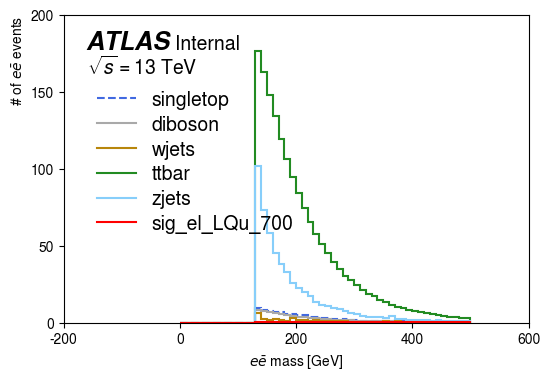

In [23]:
# Our actual plotting will proceed almost exactly as before. 
# Coffea takes care of the fact that we have multiple samples! 

fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)

out["h_dielec_mass"].plot1d(ax=ax,color=mycolorlist, linestyle=['dashed']) 

hep.style.use([hep.style.ATLAS])
hep.atlas.label(data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_ylabel('# of $e\\bar{e}$ events')
plt.show()

Note that we don't have any events below 130 GeV. This is because we've cut out events below this threshold in our preselection! 

However, we may not always want to store all of our histograms at the Processor() stage. What if we want to rebin our histograms without re-running the Processor?
One option is to save the individual event variables as arrays in the output ("out"). Below, you can see how we can recreate the di-electron mass  plot from arrays. 

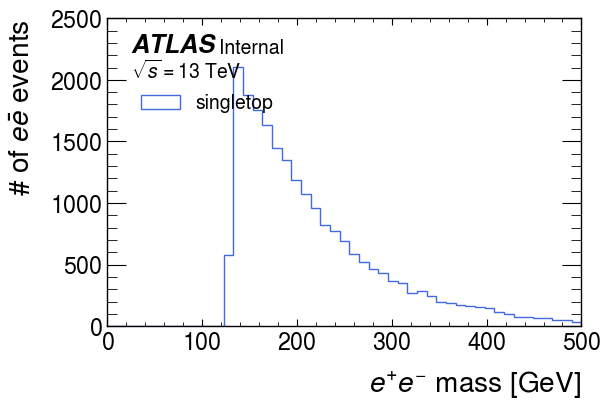

In [26]:
# Now, we'll loop through each sample in "out" and make a matplotlib hist object

fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)

for sample in out["dielec_mass"].keys(): 
    ax.hist(
        out["dielec_mass"][sample],
        color=refdict[sample]['plt_color'],
        linestyle='dashed' if 'bkg' in sample else 'solid',
        bins=np.linspace(0,500,50), 
        histtype='step',
        label=sample
    )
    
hep.style.use([hep.style.ATLAS])
hep.atlas.label(data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_xlabel('$e^{+}e^{-}$ mass [GeV]')
ax.set_ylabel('# of $e\\bar{e}$ events')
plt.show()

## Let's start by designing a selection for the e+e- channel. 

### How do we know what selection gives us the best sensitivity?
As we already mentioned, we want our selection to *maximize* the amount of signal we _accept_ and the amount of background we _reject_. To truly find the "best" selection, we would need to run our statistical analysis for all possible selections, and take which one gives us the best (lowest, in this case) limits. But, we don't have the time (or resources) to do that! 

Thankfully, we can use some simplified metrics to approximate our sensitivity. The easiest is: 
$ x = S / \sqrt{B} $ 
where $x$ is the approximate sensitivity, $S$ is the number of signal events, and $B$ is the number of background events. Note that this metric goes to infinity (i.e. gets better) as we either increase our signal or decrease our background, just as we want. 

Let'se use this equation to optimize an $m_{\ell j}$ Asymmetry cut. This variable just quantifies the difference in reconstructed LQ mass between the two LQ candidates: 
$$ m_{\ell j}^{\text{asym.}} = \frac{m_{\ell j}^{max} - m_{\ell j}^{min}}{m_{\ell j}^{max} + m_{\ell j}^{min}} $$

In [ ]:
# Plotting the m_lj asymmetry

fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)

out["h_mlq_asym"].plot1d(ax=ax,color=mycolorlist, linestyle=['dashed']) 

hep.style.use([hep.style.ATLAS])
hep.atlas.label(data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_ylabel('# of $e\\bar{e}$ events')
plt.show()

First, calculate the amount of signal and background in the total range of our analysis. 
This gives us an idea of our starting point (how we're doing without any cut). 

In [ ]:
significance_tot = {'bkg':0}

for sample in refdict:
    
    if( 'sig' in sample ): 
        # Calculate total S (for each different signal model)
        significance_tot[sample] = ak.sum( out["mlq_asym"][sample] )
    
    else: 
        # Calculate total background (our background doesn't care about the signal model, so just one entry is fine) 
        significance_tot['bkg'] += ak.sum( out["mlq_asym"][sample] )
    

print( 'Initial signficance for each signal model: ' ) 
for sample in refdict:
    if( 'sig' in sample ): 
        # Calculate s / root(b) 
        s_root_b = significance_tot[sample] / np.sqrt( significance_tot['bkg'] ) 
        print(f'   {sample} = {s_root_b}')

#### Let's now brute-force search for a better cut value by looping through possible values 

In [ ]:
# Define our list of tested cut values
mlq_asym_vals = np.linspace(0.05,1,20)
ncuts = len(mlq_asym_vals)

# Let's try manipulating these values in pandas (it will be easier for plotting in the next step) 
significance_cut_df = pd.DataFrame(
    columns=['cut','bkg']+[sample for sample in refdict if 'sig' in sample] , 
    index=range(len(mlq_asym_vals))
)

# Initialize the cut values 
significance_cut_df['cut'] = mlq_asym_vals

# Initialize the background integral as zero, since we need to add lots of processes together 
significance_cut_df['bkg'] = np.zeros( ncuts )

    
for sample in refdict:
    if( 'sig' in sample ): 
        # Calculate S (for each different signal model, for each cut value)
        significance_cut_df[sample] = np.array([ 
            ak.sum( out["mlq_asym"][sample][ out["mlq_asym"][sample] < cutval ] ) 
            for cutval in mlq_asym_vals
        ])

    else: 
        # Calculate background for each cut value
        significance_cut_df['bkg'] += np.array([ 
            ak.sum( out["mlq_asym"][sample][ out["mlq_asym"][sample] < cutval ] ) 
            for cutval in mlq_asym_vals
        ])

      
for sample in refdict:
    if( 'sig' in sample ): 
        significance_cut_df[f'{sample}_s_root_b'] = significance_cut_df[sample] / np.sqrt( significance_cut_df['bkg'] )

significance_cut_df

In [ ]:
# Now we can plot the s/root(b) for each signal model as a function of the cut value 

# Plotting the m_lj asymmetry

fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)

for sample in refdict:
    if( 'sig' in sample ): 
        ax.plot( 
            mlq_asym_vals , 
            significance_cut_df[f'{sample}_s_root_b'] , 
            color = refdict[sample]['plt_color'] , 
            label=sample 
        )
    
hep.style.use([hep.style.ATLAS])
hep.atlas.label(data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_xlabel('Cut Value: $m_\ell j}^{Asymm.}$') 
ax.set_ylabel('# of $e\\bar{e}$ events')
plt.show()

In [ ]:
# Get the "best" cut value by maximizing significance 

for sample in refdict:
    if( 'sig' in sample ): 
        bestvalue = significance_cut_df['cut'][ np.argmax( significance_cut_df[f'{sample}_s_root_b'] ) ]
        print( f'Best cut for {sample} = {bestvalue}' )

In [ ]:

fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)
    
out["h_mlq_avg"].plot1d(ax=ax,color=mycolorlist) 

hep.style.use([hep.style.ATLAS])
hep.atlas.label(data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_xlabel('$m_{\ell q}^{Avg}$ Sig. [GeV]')
ax.set_ylabel('# of $e\\bar{e}$ events')
plt.show()

In [ ]:

fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)
    
out["h_met_sig"].plot1d(ax=ax,color=mycolorlist) 

hep.style.use([hep.style.ATLAS])
hep.atlas.label(data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.01, 0.85), loc="upper left")

ax.set_xlabel('$E_{T}^{Miss}$ Sig. [GeV]')
ax.set_ylabel('# of $e\\bar{e}$ events')
plt.show()
